In [ ]:
pip install tzdata

In [ ]:
pip install geopy --no-cache-dir

In [ ]:
pip install seaborn --no-cache-dir

In [ ]:
pip install mpu --no-cache-dir

In [ ]:
pip install currencyconverter --no-cache-dir

In [ ]:
pip install sklearn --no-cache-dir

In [ ]:
pip install matplotlib --no-cache-dir

In [ ]:
pip install xgboost --no-cache-dir

In [ ]:
pip install imbalanced-learn==0.8 --no-cache-dir

In [ ]:
pip install tensorflow --no-cache-dir

Initial assumptions
1. For modelling purposes I took only data of flights with minimum of 25 search queries run on given connection (origin->destination).
2. Most fligths which were of intersts in search database were within 90 days period before flight departure (time2flight_dy feature < 90) - so I limited forecasting range to fares only within those days. 
3. In case of measure of success evaluation except minimaizing the mean absolut error of forecast I will take into account smoothnes and stability of forecasted fare trend line

In [2]:
from io import StringIO
from statistics import median_low
from string import ascii_lowercase

import lxml.etree as et
import numpy as np
import pandas as pd
import seaborn as sns

# import sklearn

srch = pd.read_csv("Copy of search_data.csv")
# srch.head(10).T

<ipython-input-2-e8c538f30e80>:12: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  srch = pd.read_csv("Copy of search_data.csv")


In [3]:
arp = pd.read_csv("Copy of airport_data.csv")
arp.head(10)

,iata_code,city,country,latitude,longitude,altitude,timezone,dst,aggregate_code
0,NYC,New York,United States,40.7142,-74.005800,31.0,-5.0,A,1.0
1,QSF,San Francisco,United States,NaN,NaN,NaN,-8.0,NaN,1.0
2,CHI,Chicago,United States,41.8836,-87.631700,596.0,-6.0,A,1.0
3,PAR,Paris,France,48.8564,2.352220,107.0,1.0,E,1.0
4,WAS,Washington,United States,38.8894,-77.035300,25.0,-5.0,A,1.0
5,LON,London,United Kingdom,51.5081,-0.127778,66.0,0.0,E,1.0
6,DFW,Dallas,United States,NaN,NaN,NaN,-6.0,NaN,1.0
7,HOU,Houston,United States,NaN,NaN,NaN,-6.0,NaN,1.0
8,BER,Berlin,Germany,NaN,NaN,NaN,1.0,NaN,1.0
9,MOW,Moscow,Russia,NaN,NaN,NaN,3.0,NaN,1.0


In [4]:
# deduplicating data
arp2 = arp.drop_duplicates(["iata_code"])

In [5]:
arp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5776 entries, 0 to 5822
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   iata_code       5776 non-null   object 
 1   city            5776 non-null   object 
 2   country         5776 non-null   object 
 3   latitude        5721 non-null   float64
 4   longitude       5721 non-null   float64
 5   altitude        5657 non-null   float64
 6   timezone        5723 non-null   float64
 7   dst             5671 non-null   object 
 8   aggregate_code  5724 non-null   float64
dtypes: float64(5), object(4)
memory usage: 451.2+ KB


In [6]:
arp2.isna().sum().sort_values()

iata_code           0
city                0
country             0
aggregate_code     52
timezone           53
latitude           55
longitude          55
dst               105
altitude          119
dtype: int64

In [7]:
# deduplicating data
srch2 = srch.drop_duplicates(["search_id"])

In [8]:
srch2.groupby(["search_id"]).agg({"itinerary_id": "count"}).sort_values(
    "itinerary_id", ascending=False
)

,itinerary_id
search_id,
0000001c-1863-4865-a917-b0281190a278,1
028aaa21-b447-46c1-9416-812749ff7442,1
028a7e21-28d1-4b1f-8aa9-fa9bf924128b,1
028a824f-54d0-4221-b08d-74b65a533b3d,1
028a91c6-8a85-4098-8884-88c853f730b0,1
...,...
02367ceb-fbef-491e-9dbf-5a4dd566c04d,0
02367cf1-a05c-4991-9ff8-1ec6203b5348,0
02367cfb-b481-44b1-a2cf-1e04e19e8c82,0


In [9]:
# joining fligth data with airports

srch2 = pd.merge(srch2, arp2, left_on=["origin"], right_on=["iata_code"], how="inner")
arp2_dst = arp2.copy()
arp2_dst.rename(
    columns={
        "timezone": "timezone_dst",
        "iata_code": "iata_code_dst",
        "dst": "dst_dst",
    },
    inplace=True,
)
srch2 = pd.merge(
    srch2,
    arp2_dst[["iata_code_dst", "timezone_dst", "dst_dst"]],
    left_on=["destination"],
    right_on=["iata_code_dst"],
    how="inner",
)

In [10]:
srch2.rename(
    columns={
        "timezone": "timezone_org",
        "iata_code": "iata_code_org",
        "dst": "dst_org",
    },
    inplace=True,
)

In [11]:
# spliting departure a arrival agregated flight dates on single dates

srch2[
    [
        "departure_datetime_11",
        "departure_datetime_12",
        "departure_datetime_13",
        "departure_datetime_14",
        "departure_datetime_15",
        "departure_datetime_16",
        "departure_datetime_17",
    ]
] = srch2["departure_datetime_1"].str.split(";", 6, expand=True)
srch2[
    [
        "arrival_datetime_11",
        "arrival_datetime_12",
        "arrival_datetime_13",
        "arrival_datetime_14",
        "arrival_datetime_15",
        "arrival_datetime_16",
        "arrival_datetime_17",
    ]
] = srch2["arrival_datetime_1"].str.split(";", 6, expand=True)
srch2[
    [
        "departure_datetime_21",
        "departure_datetime_22",
        "departure_datetime_23",
        "departure_datetime_24",
        "departure_datetime_25",
    ]
] = srch2["departure_datetime_2"].str.split(";", 4, expand=True)
srch2[
    [
        "arrival_datetime_21",
        "arrival_datetime_22",
        "arrival_datetime_23",
        "arrival_datetime_24",
        "arrival_datetime_25",
    ]
] = srch2["arrival_datetime_2"].str.split(";", 4, expand=True)

In [12]:
# replacing nan's with 0's

srch2["timezone_org"].replace({np.nan: 0}, inplace=True)
srch2["timezone_dst"].replace({np.nan: 0}, inplace=True)

In [580]:
# cleaning dates - cutting outliers and miscoded dates

srch3 = srch2[
    ((srch2["departure_datetime_11"] < "2018-01-01 00:00:00")
 & (srch2['arrival_datetime_11']>='2017-01-01 00:00:00'))]

In [ ]:
# calculating flight stops no.

srch3["stops_fl1"] = srch3["flight_num_1"].str.count(";")
# srch2['stops_fl1'].max()
srch3["stops_fl2"] = srch3["flight_num_2"].str.count(";")
srch3["stops_fl2"].max()

In [583]:
# preparing timezones for date localization with airports zones

srch3["timezone_org"] = srch3["timezone_org"].astype(int)
srch3["timezone_dst"] = srch3["timezone_dst"].astype(int)
srch3["tz_o"] = srch3["timezone_org"].apply(
    lambda x: "Etc/GMT+" + str(-x) if x < 0 else "Etc/GMT-" + str(x)
)
srch3["tz_d"] = srch3["timezone_dst"].apply(
    lambda x: "Etc/GMT+" + str(-x) if x < 0 else "Etc/GMT-" + str(x)
)

<ipython-input-583-c2a53f1879b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srch3["timezone_org"] = srch3["timezone_org"].astype(int)
<ipython-input-583-c2a53f1879b3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srch3["timezone_dst"] = srch3["timezone_dst"].astype(int)
<ipython-input-583-c2a53f1879b3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [584]:
# reseting existing timezones on dates - not all date have one - so it is for standarization purposes

import datetime

srch3["departure_datetime_11"] = pd.to_datetime(srch3["departure_datetime_11"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
)

srch3["arrival_datetime_11"] = pd.to_datetime(srch3["arrival_datetime_11"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
)
srch3["arrival_datetime_12"] = pd.to_datetime(srch3["arrival_datetime_12"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
    if isinstance(old_datetime, datetime.date)
    else old_datetime
)
srch3["arrival_datetime_13"] = pd.to_datetime(srch3["arrival_datetime_13"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
    if isinstance(old_datetime, datetime.date)
    else old_datetime
)
srch3["arrival_datetime_14"] = pd.to_datetime(srch3["arrival_datetime_14"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
    if isinstance(old_datetime, datetime.date)
    else old_datetime
)
srch3["arrival_datetime_15"] = pd.to_datetime(srch3["arrival_datetime_15"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
    if isinstance(old_datetime, datetime.date)
    else old_datetime
)
srch3["arrival_datetime_16"] = pd.to_datetime(srch3["arrival_datetime_16"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
    if old_datetime != None
    else old_datetime
)  # isinstance(old_datetime, datetime.date) else old_datetime)
srch3["arrival_datetime_17"] = pd.to_datetime(srch3["arrival_datetime_17"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
    if old_datetime != None
    else old_datetime
)  # if isinstance(old_datetime, datetime.date) else old_datetime)

srch3["departure_datetime_21"] = pd.to_datetime(srch3["departure_datetime_21"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
    if isinstance(old_datetime, datetime.date)
    else old_datetime
)

srch3["arrival_datetime_21"] = pd.to_datetime(srch3["arrival_datetime_21"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
    if isinstance(old_datetime, datetime.date)
    else old_datetime
)
srch3["arrival_datetime_22"] = pd.to_datetime(srch3["arrival_datetime_22"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
    if isinstance(old_datetime, datetime.date)
    else old_datetime
)
srch3["arrival_datetime_23"] = pd.to_datetime(srch3["arrival_datetime_23"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
    if isinstance(old_datetime, datetime.date)
    else old_datetime
)
srch3["arrival_datetime_24"] = pd.to_datetime(srch3["arrival_datetime_24"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
    if isinstance(old_datetime, datetime.date)
    else old_datetime
)
srch3["arrival_datetime_25"] = pd.to_datetime(srch3["arrival_datetime_25"]).apply(
    lambda old_datetime: old_datetime.replace(tzinfo=None)
    if isinstance(old_datetime, datetime.date)
    else old_datetime
)

<ipython-input-584-073a914630a2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srch3["departure_datetime_11"] = pd.to_datetime(srch3["departure_datetime_11"]).apply(
<ipython-input-584-073a914630a2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srch3["arrival_datetime_11"] = pd.to_datetime(srch3["arrival_datetime_11"]).apply(
<ipython-input-584-073a914630a2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [585]:
# adding timezones to dates connected with origin and destinastion airport - only the first and last is used for flight duration calculations

srch3["departure_datetime_11_tz"] = srch3.apply(
    lambda x: x["departure_datetime_11"].tz_localize(x["tz_o"]), axis=1
)

srch3["arrival_datetime_11_tz"] = srch3.apply(
    lambda x: x["arrival_datetime_11"].tz_localize(x["tz_d"]), axis=1
)
srch3["arrival_datetime_12_tz"] = srch3.apply(
    lambda x: x["arrival_datetime_12"].tz_localize(x["tz_d"])
    if x["arrival_datetime_12"] != None
    else x["arrival_datetime_12"],
    axis=1,
)
srch3["arrival_datetime_13_tz"] = srch3.apply(
    lambda x: x["arrival_datetime_13"].tz_localize(x["tz_d"])
    if x["arrival_datetime_13"] != None
    else x["arrival_datetime_13"],
    axis=1,
)
srch3["arrival_datetime_14_tz"] = srch3.apply(
    lambda x: x["arrival_datetime_14"].tz_localize(x["tz_d"])
    if x["arrival_datetime_14"] != None
    else x["arrival_datetime_14"],
    axis=1,
)
srch3["arrival_datetime_15_tz"] = srch3.apply(
    lambda x: x["arrival_datetime_15"].tz_localize(x["tz_d"])
    if x["arrival_datetime_15"] != None
    else x["arrival_datetime_15"],
    axis=1,
)
srch3["arrival_datetime_16_tz"] = srch3.apply(
    lambda x: x["arrival_datetime_16"].tz_localize(x["tz_d"])
    if x["arrival_datetime_16"] != None
    else x["arrival_datetime_16"],
    axis=1,
)
srch3["arrival_datetime_17_tz"] = srch3.apply(
    lambda x: x["arrival_datetime_17"].tz_localize(x["tz_d"])
    if x["arrival_datetime_17"] != None
    else x["arrival_datetime_17"],
    axis=1,
)

srch3["departure_datetime_21_tz"] = srch3.apply(
    lambda x: x["departure_datetime_21"].tz_localize(x["tz_d"])
    if x["departure_datetime_21"] != None
    else x["departure_datetime_21"],
    axis=1,
)

srch3["arrival_datetime_21_tz"] = srch3.apply(
    lambda x: x["arrival_datetime_21"].tz_localize(x["tz_o"])
    if x["arrival_datetime_21"] != None
    else x["arrival_datetime_21"],
    axis=1,
)
srch3["arrival_datetime_22_tz"] = srch3.apply(
    lambda x: x["arrival_datetime_22"].tz_localize(x["tz_o"])
    if x["arrival_datetime_22"] != None
    else x["arrival_datetime_22"],
    axis=1,
)
srch3["arrival_datetime_23_tz"] = srch3.apply(
    lambda x: x["arrival_datetime_23"].tz_localize(x["tz_o"])
    if x["arrival_datetime_23"] != None
    else x["arrival_datetime_23"],
    axis=1,
)
srch3["arrival_datetime_24_tz"] = srch3.apply(
    lambda x: x["arrival_datetime_24"].tz_localize(x["tz_o"])
    if x["arrival_datetime_24"] != None
    else x["arrival_datetime_24"],
    axis=1,
)
srch3["arrival_datetime_25_tz"] = srch3.apply(
    lambda x: x["arrival_datetime_25"].tz_localize(x["tz_o"])
    if x["arrival_datetime_25"] != None
    else x["arrival_datetime_25"],
    axis=1,
)

<ipython-input-585-5b1f48d214ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srch3["departure_datetime_11_tz"] = srch3.apply(
<ipython-input-585-5b1f48d214ca>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srch3["arrival_datetime_11_tz"] = srch3.apply(
<ipython-input-585-5b1f48d214ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [586]:
# converting all dates to UTC timezone for proper time calculations

srch3["departure_datetime_11_utc"] = pd.to_datetime(
    srch3["departure_datetime_11_tz"], utc=True
).dt.tz_convert("UTC")

srch3["arrival_datetime_11_utc"] = pd.to_datetime(
    srch3["arrival_datetime_11_tz"], utc=True
).dt.tz_convert("UTC")
srch3["arrival_datetime_12_utc"] = pd.to_datetime(
    srch3["arrival_datetime_12_tz"], utc=True
).dt.tz_convert("UTC")
srch3["arrival_datetime_13_utc"] = pd.to_datetime(
    srch3["arrival_datetime_13_tz"], utc=True
).dt.tz_convert("UTC")
srch3["arrival_datetime_14_utc"] = pd.to_datetime(
    srch3["arrival_datetime_14_tz"], utc=True
).dt.tz_convert("UTC")
srch3["arrival_datetime_15_utc"] = pd.to_datetime(
    srch3["arrival_datetime_15_tz"], utc=True
).dt.tz_convert("UTC")
srch3["arrival_datetime_16_utc"] = pd.to_datetime(
    srch3["arrival_datetime_16_tz"], utc=True
).dt.tz_convert("UTC")
srch3["arrival_datetime_17_utc"] = pd.to_datetime(
    srch3["arrival_datetime_17_tz"], utc=True
).dt.tz_convert("UTC")

srch3["departure_datetime_21_utc"] = pd.to_datetime(
    srch3["departure_datetime_21_tz"], utc=True
).dt.tz_convert("UTC")

srch3["arrival_datetime_21_utc"] = pd.to_datetime(
    srch3["arrival_datetime_21_tz"], utc=True
).dt.tz_convert("UTC")
srch3["arrival_datetime_22_utc"] = pd.to_datetime(
    srch3["arrival_datetime_22_tz"], utc=True
).dt.tz_convert("UTC")
srch3["arrival_datetime_23_utc"] = pd.to_datetime(
    srch3["arrival_datetime_23_tz"], utc=True
).dt.tz_convert("UTC")
srch3["arrival_datetime_24_utc"] = pd.to_datetime(
    srch3["arrival_datetime_24_tz"], utc=True
).dt.tz_convert("UTC")
srch3["arrival_datetime_25_utc"] = pd.to_datetime(
    srch3["arrival_datetime_25_tz"], utc=True
).dt.tz_convert("UTC")

<ipython-input-586-af3086b3a8c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srch3["departure_datetime_11_utc"] = pd.to_datetime(
<ipython-input-586-af3086b3a8c5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srch3["arrival_datetime_11_utc"] = pd.to_datetime(
<ipython-input-586-af3086b3a8c5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [587]:
# intermedied data frames for first and last date calculation

srch31 = srch3[
    [
        "search_id",
        "arrival_datetime_11_utc",
        "arrival_datetime_12_utc",
        "arrival_datetime_13_utc",
        "arrival_datetime_14_utc",
        "arrival_datetime_15_utc",
        "arrival_datetime_16_utc",
        "arrival_datetime_17_utc",
        "arrival_datetime_11_tz",
        "arrival_datetime_12_tz",
        "arrival_datetime_13_tz",
        "arrival_datetime_14_tz",
        "arrival_datetime_15_tz",
        "arrival_datetime_16_tz",
        "arrival_datetime_17_tz",
    ]
]
srch32 = srch3[
    [
        "search_id",
        "arrival_datetime_21_utc",
        "arrival_datetime_22_utc",
        "arrival_datetime_23_utc",
        "arrival_datetime_24_utc",
        "arrival_datetime_25_utc",
        "arrival_datetime_21_tz",
        "arrival_datetime_22_tz",
        "arrival_datetime_23_tz",
        "arrival_datetime_24_tz",
        "arrival_datetime_25_tz",
    ]
]

In [588]:
# additional calculation for placing last date in last column for simplicity

srch31["arrival_1_last_utc"] = (
    srch31[
        [
            "arrival_datetime_11_utc",
            "arrival_datetime_12_utc",
            "arrival_datetime_13_utc",
            "arrival_datetime_14_utc",
            "arrival_datetime_15_utc",
            "arrival_datetime_16_utc",
            "arrival_datetime_17_utc",
        ]
    ]
    .fillna(method="ffill", axis=1)
    .max(axis=1, skipna=True)
)
srch32["arrival_2_last_utc"] = (
    srch32[
        [
            "arrival_datetime_21_utc",
            "arrival_datetime_22_utc",
            "arrival_datetime_23_utc",
            "arrival_datetime_24_utc",
            "arrival_datetime_25_utc",
        ]
    ]
    .fillna(method="ffill", axis=1)
    .max(axis=1, skipna=True)
)
srch31["arrival_1_last_tz"] = (
    srch31[
        [
            "arrival_datetime_11_tz",
            "arrival_datetime_12_tz",
            "arrival_datetime_13_tz",
            "arrival_datetime_14_tz",
            "arrival_datetime_15_tz",
            "arrival_datetime_16_tz",
            "arrival_datetime_17_tz",
        ]
    ]
    .fillna(method="ffill", axis=1)
    .max(axis=1, skipna=True)
)
srch32["arrival_2_last_tz"] = (
    srch32[
        [
            "arrival_datetime_21_tz",
            "arrival_datetime_22_tz",
            "arrival_datetime_23_tz",
            "arrival_datetime_24_tz",
            "arrival_datetime_25_tz",
        ]
    ]
    .fillna(method="ffill", axis=1)
    .max(axis=1, skipna=True)
)

<ipython-input-588-257d219e2a48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srch31["arrival_1_last_utc"] = (
<ipython-input-588-257d219e2a48>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srch32["arrival_2_last_utc"] = (
<ipython-input-588-257d219e2a48>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [589]:
# joining additional data frames with main table

srch4 = pd.merge(
    srch3,
    srch31[["search_id", "arrival_1_last_utc", "arrival_1_last_tz"]],
    left_on=["search_id"],
    right_on=["search_id"],
    how="inner",
)
srch4 = pd.merge(
    srch4,
    srch32[["search_id", "arrival_2_last_utc", "arrival_2_last_tz"]],
    left_on=["search_id"],
    right_on=["search_id"],
    how="left",
)

In [590]:
# dropping not needed columns

srch4.drop(
    [
        "arrival_datetime_11_utc",
        "arrival_datetime_12_utc",
        "arrival_datetime_13_utc",
        "arrival_datetime_14_utc",
        "arrival_datetime_15_utc",
        "arrival_datetime_16_utc",
        "arrival_datetime_17_utc",
        "arrival_datetime_11",
        "arrival_datetime_12",
        "arrival_datetime_13",
        "arrival_datetime_14",
        "arrival_datetime_15",
        "arrival_datetime_16",
        "arrival_datetime_17",
        "arrival_datetime_11_tz",
        "arrival_datetime_12_tz",
        "arrival_datetime_13_tz",
        "arrival_datetime_14_tz",
        "arrival_datetime_15_tz",
        "arrival_datetime_16_tz",
        "arrival_datetime_17_tz",
        "arrival_datetime_21_tz",
        "arrival_datetime_22_tz",
        "arrival_datetime_23_tz",
        "arrival_datetime_24_tz",
        "arrival_datetime_25_tz",
        "arrival_datetime_21",
        "arrival_datetime_22",
        "arrival_datetime_23",
        "arrival_datetime_24",
        "arrival_datetime_25",
        "departure_datetime_12",
        "departure_datetime_13",
        "departure_datetime_14",
        "departure_datetime_15",
        "departure_datetime_16",
        "departure_datetime_17",
        "departure_datetime_22",
        "departure_datetime_23",
        "departure_datetime_24",
        "departure_datetime_25",
        "arrival_datetime_21_utc",
        "arrival_datetime_22_utc",
        "arrival_datetime_23_utc",
        "arrival_datetime_24_utc",
        "arrival_datetime_25_utc",
    ],
    axis=1,
    inplace=True,
)

In [591]:
# calculation of durations of flights in hours and time to departure form search time perspective

srch4["duration_fl1_h"] = (
    srch4["arrival_1_last_utc"] - srch4["departure_datetime_11_utc"]
).dt.total_seconds() / 3600
srch4["duration_fl2_h"] = (
    srch4["arrival_2_last_utc"] - srch4["departure_datetime_21_utc"]
).dt.total_seconds() / 3600
srch4["time2flight_dy"] = (
    srch4["departure_datetime_11_utc"]
    - pd.to_datetime(srch4["search_time"]).dt.tz_localize("UTC")
).dt.total_seconds() / 86400  #  .dt.tz_convert("UTC")

In [592]:
arp2_dst.rename(
    columns={
        "latitude": "latitude_dst",
        "iata_code": "iata_code_dst",
        "longitude": "longitude_dst",
    },
    inplace=True,
)
srch5 = pd.merge(
    srch4,
    arp2_dst[["iata_code_dst", "latitude_dst", "longitude_dst"]],
    left_on=["destination"],
    right_on=["iata_code_dst"],
    how="inner",
)

In [593]:
# calculating distance betweend origin and distination airport

import mpu

srch5["distance_km"] = srch5.apply(
    lambda x: mpu.haversine_distance(
        (x["latitude"], x["longitude"]), (x["latitude_dst"], x["longitude_dst"])
    )
    if (
        ((x["latitude"] >= -90) & (x["latitude"] <= 90))
        & ((x["latitude_dst"] >= -90) & (x["latitude_dst"] <= 90))
        & ((x["longitude"] >= -180) & (x["longitude"] <= 180))
        & ((x["longitude_dst"] >= -180) & (x["longitude_dst"] <= 180))
    )
    else np.nan,
    axis=1,
)

In [594]:
# cleaning date of errors in dates notation - flight time shorter then it looks like concernig timezone differences

srch6 = srch5[
    ~(
        (
            srch5["duration_fl1_h"]
            < abs(srch5["timezone_dst"].astype(int) - srch5["timezone_org"].astype(int))
        )
        & (
            srch5["duration_fl1_h"]
            < (
                24
                - abs(
                    srch5["timezone_dst"].astype(int)
                    - srch5["timezone_org"].astype(int)
                )
            )
        )
    )
]

In [595]:
srch7 = srch6[
    ~(
        (
            srch6["duration_fl2_h"]
            < abs(srch6["timezone_dst"].astype(int) - srch6["timezone_org"].astype(int))
        )
        & (
            srch6["duration_fl2_h"]
            < (
                24
                - abs(
                    srch6["timezone_dst"].astype(int)
                    - srch6["timezone_org"].astype(int)
                )
            )
        )
    )
].copy()

In [596]:
df13 = pd.DataFrame(
    srch7.groupby(["currency"]).agg({"itinerary_id": "count"}).to_records()
)

In [597]:
df13[df13["itinerary_id"] > 0]

,currency,itinerary_id
0,AED,45
6,AUD,168
20,CAD,360
22,CHF,54
24,CNY,8
27,CZK,5
28,DKK,86
33,EUR,24199
35,GBP,1128
41,HKD,50


In [598]:
# converting all used in flights currencies do USD

from currency_converter import CurrencyConverter

c = CurrencyConverter()

srch7["curr2usd"] = srch7["currency"].apply(
    lambda x: np.where(x == "AED", 367, c.convert(100, x, "USD"))
    if x
    in (
        "AUD",
        "CAD",
        "CHF",
        "CNY",
        "CZK",
        "DKK",
        "EUR",
        "GBP",
        "HKD",
        "HUF",
        "ISK",
        "JPY",
        "KRW",
        "MXN",
        "MYR",
        "NOK",
        "NZD",
        "PHP",
        "SEK",
        "SGD",
        "THB",
        "USD",
        "ZAR",
    )
    else np.nan
)

In [599]:
# calculating fare in USD

srch7["fare_usd"] = srch7.apply(
    lambda x: ((x["fare"]) / (x["curr2usd"])) * 100
    if ((~(x["fare"] != None)) & (~(x["curr2usd"] != None)))
    else np.nan,
    axis=1,
)

In [600]:
srch8 = srch7.copy()

In [601]:
srch7.groupby(["cabin_class"]).agg({"itinerary_id": "count"})

,itinerary_id
cabin_class,
Business,36
COACH,2
ECONOMY,0
Economy,10761
First,10
First Class,2
Premium Economy,10
business,241
economy,89400


In [602]:
# standarizing cabin class names

srch7["cabin_class"].replace(
    {
        "ECONOMY": "economy",
        "Economy": "economy",
        "Business": "business",
        "First": "first",
        "First Class": "first",
        "premiumEconomy": "premium_economy",
        "Premium Economy": "premium_economy",
        "premiumEconomy": "premium_economy",
        "Unknown": 6,
    },
    inplace=True,
)

<AxesSubplot:ylabel='itinerary_id'>

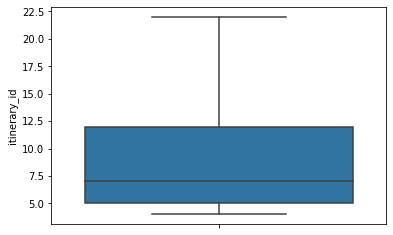

In [603]:
# checking the distribution of number of itinerarys on given route

df = srch7.groupby(["origin", "destination"]).agg({"itinerary_id": "count"})
sns.boxplot(y="itinerary_id", data=df.where(df["itinerary_id"] > 3), showfliers=False)

In [604]:
df4 = (
    srch7.groupby(["origin", "destination"])
    .agg({"itinerary_id": "count"})
    .sort_values("itinerary_id", ascending=False)
)  # .where('itinerary_id'>10)
df5 = pd.DataFrame(df4.to_records())

In [605]:
itnr = df5[df5["itinerary_id"] > 0].copy()
itnr.rename(columns={"itinerary_id": "itinr_cnt"}, inplace=True)

In [606]:
itnr

,origin,destination,itinr_cnt
0,BRU,CPH,427
1,AMS,DPS,341
2,REK,LON,338
3,AMS,KEF,330
4,AMS,BKK,327
...,...,...,...
26337,NRT,KLO,1
26338,NTE,NOU,1
26339,BUE,SEL,1
26340,TLH,LGA,1


In [607]:
# adding itineraries number on given route do main table

srch8 = pd.merge(
    srch7,
    itnr,
    left_on=["origin", "destination"],
    right_on=["origin", "destination"],
    how="inner",
).copy()

In [655]:
# limiting table to only routes with more then 25 flights

srch9 = srch8[srch8["itinr_cnt"] > 25].copy()

In [656]:
srch9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287244 entries, 0 to 998397
Data columns (total 61 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   search_id                  287244 non-null  object             
 1   search_time                287244 non-null  object             
 2   currency                   287244 non-null  object             
 3   destination                287244 non-null  object             
 4   search_user_id             287244 non-null  object             
 5   language                   287244 non-null  object             
 6   origin                     287244 non-null  object             
 7   partner_id                 287244 non-null  int64              
 8   passengers                 287244 non-null  int64              
 9   pos                        286434 non-null  object             
 10  session_id                 287244 non-null  object      

In [657]:
# calculatin hours and months parts of key dates

srch9["search_time_hour"] = pd.to_datetime(
    srch9["search_time"], format="%Y-%m-%d %H:%M:%S"
).dt.hour
srch9["search_time_weekday"] = pd.to_datetime(
    srch9["search_time"], format="%Y-%m-%d %H:%M:%S"
).dt.weekday
srch9["departure_1_hour"] = pd.to_datetime(
    srch9["departure_datetime_11"], format="%d/%m/%Y"
).dt.hour
srch9["departure_1_weekday"] = pd.to_datetime(
    srch9["departure_datetime_11"], format="%d/%m/%Y"
).dt.weekday
srch9["arrival_1_hour"] = pd.to_datetime(
    srch9["arrival_1_last_tz"], format="%Y-%m-%d %H:%M:%S%z", utc=True
).dt.hour
srch9["departure_2_hour"] = pd.to_datetime(
    srch9["departure_datetime_21"], format="%d/%m/%Y"
).dt.hour
srch9["arrival_2_hour"] = pd.to_datetime(
    srch9["arrival_2_last_tz"], format="%Y-%m-%d %H:%M:%S%z", utc=True
).dt.hour
srch9["departure_1_month"] = pd.to_datetime(
    srch9["departure_datetime_11"], format="%d/%m/%Y"
).dt.month
srch9["arrival_1_month"] = pd.to_datetime(
    srch9["arrival_1_last_tz"], format="%Y-%m-%d %H:%M:%S%z", utc=True
).dt.month
srch9["departure_2_month"] = pd.to_datetime(
    srch9["departure_datetime_21"], format="%d/%m/%Y"
).dt.month
srch9["arrival_2_month"] = pd.to_datetime(
    srch9["arrival_2_last_tz"], format="%Y-%m-%d %H:%M:%S%z", utc=True
).dt.month

In [658]:
srch9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287244 entries, 0 to 998397
Data columns (total 72 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   search_id                  287244 non-null  object             
 1   search_time                287244 non-null  object             
 2   currency                   287244 non-null  object             
 3   destination                287244 non-null  object             
 4   search_user_id             287244 non-null  object             
 5   language                   287244 non-null  object             
 6   origin                     287244 non-null  object             
 7   partner_id                 287244 non-null  int64              
 8   passengers                 287244 non-null  int64              
 9   pos                        286434 non-null  object             
 10  session_id                 287244 non-null  object      

In [659]:
# segmenting hours of search time based on distribution

srch9["search_time_hour_cat"] = srch9["search_time_hour"].map(
    {
        0: "night",
        1: "night",
        2: "night",
        3: "night",
        4: "night",
        5: "night",
        6: "night",
        7: "night",
        8: "night",
        9: "noon",
        10: "noon",
        11: "noon",
        12: "noon",
        13: "noon",
        14: "noon",
        15: "noon",
        16: "evening",
        17: "evening",
        18: "evening",
        19: "evening",
        20: "evening",
        21: "evening",
        22: "evening",
        23: "evening"
    }
)

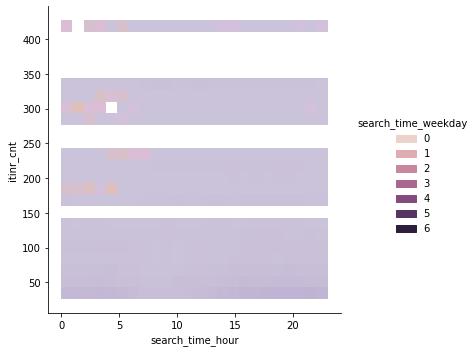

In [660]:
sns.displot(
    data=srch9, x="search_time_hour", y="itinr_cnt", hue="search_time_weekday", bins=24
)  # , kde = True)

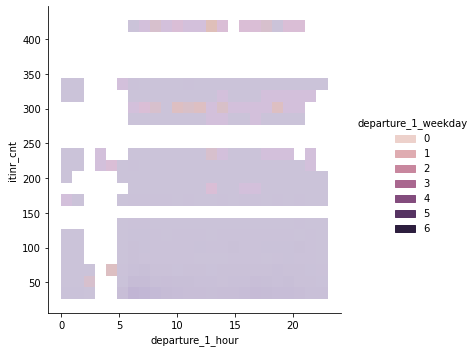

In [661]:
sns.displot(
    data=srch9, x="departure_1_hour", y="itinr_cnt", hue="departure_1_weekday", bins=24
)  # , kde = True)

In [662]:
# the same with other dates

srch9["departure_1_hour_cat"] = srch9["departure_1_hour"].map(
    {
        0: "night",
        1: "night",
        2: "night",
        3: "night",
        4: "night",
        5: "night",
        6: "morning",
        7: "morning",
        8: "morning",
        9: "morning",
        10: "noon",
        11: "noon",
        12: "noon",
        13: "noon",
        14: "noon",
        15: "noon",
        16: "evening",
        17: "evening",
        18: "evening",
        19: "evening",
        20: "evening",
        21: "evening",
        22: "evening",
        23: "evening",
    }
)

In [663]:
srch9["departure_2_hour_cat"] = srch9["departure_2_hour"].map(
    {
        0: "night",
        1: "night",
        2: "night",
        3: "night",
        4: "night",
        5: "night",
        6: "morning",
        7: "morning",
        8: "morning",
        9: "morning",
        10: "noon",
        11: "noon",
        12: "noon",
        13: "noon",
        14: "noon",
        15: "noon",
        16: "evening",
        17: "evening",
        18: "evening",
        19: "evening",
        20: "evening",
        21: "evening",
        22: "evening",
        23: "evening",
    }
)

In [664]:
srch9["arrival_1_hour_cat"] = srch9["arrival_1_hour"].map(
    {
        0: "night",
        1: "night",
        2: "night",
        3: "night",
        4: "night",
        5: "night",
        6: "morning",
        7: "morning",
        8: "morning",
        9: "morning",
        10: "noon",
        11: "noon",
        12: "noon",
        13: "noon",
        14: "noon",
        15: "noon",
        16: "evening",
        17: "evening",
        18: "evening",
        19: "evening",
        20: "evening",
        21: "evening",
        22: "evening",
        23: "evening",
    }
)

In [665]:
srch9["arrival_2_hour_cat"] = srch9["arrival_2_hour"].map(
    {
        0: "night",
        1: "night",
        2: "night",
        3: "night",
        4: "night",
        5: "night",
        6: "morning",
        7: "morning",
        8: "morning",
        9: "morning",
        10: "noon",
        11: "noon",
        12: "noon",
        13: "noon",
        14: "noon",
        15: "noon",
        16: "evening",
        17: "evening",
        18: "evening",
        19: "evening",
        20: "evening",
        21: "evening",
        22: "evening",
        23: "evening",
    }
)

In [666]:
# splitin agregated data of user_agent info to more convienient form

srch9[["agent", "agent_rest1"]] = srch9["user_agent"].str.split("/", 1, expand=True)

In [667]:
srch9[["agent_trash", "agent_rest2"]] = srch9["agent_rest1"].str.split(
    "(", 1, expand=True
)

In [668]:
srch9[["os", "agent_rest3"]] = srch9["agent_rest2"].str.split(";", 1, expand=True)

In [669]:
srch9[["agent", "os"]]

,agent,os
0,Dalvik,Linux
1,Mozilla,iPhone
2,Mozilla,iPhone
3,Mozilla,Windows NT 10.0
4,Mozilla,Macintosh
...,...,...
998393,Mozilla,Linux
998394,Mozilla,Windows NT 6.2
998395,Mozilla,iPhone
998396,Mozilla,iPad


In [670]:
# segmenting the distance feature

srch9["distance_cat"] = srch9["distance_km"].apply(
    lambda x: round(x / 1000) if (~(np.isnan(x))) else np.nan
)

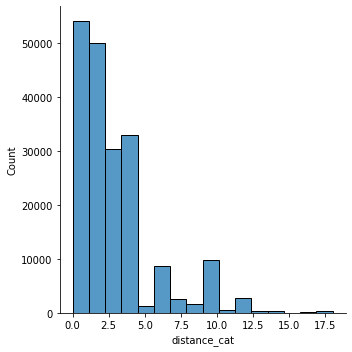

In [671]:
sns.displot(srch9["distance_cat"], bins=16, kde=False)

In [672]:
srch9["distance_cat2"] = srch9["distance_cat"].apply(
    lambda x: np.where(np.isnan(x), np.nan, 13) if (x >= 13) else x
)

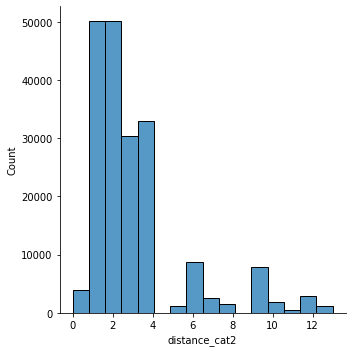

In [673]:
sns.displot(srch9["distance_cat2"], bins=16, kde=False)

In [674]:
max(srch9[~(np.isnan(srch9["distance_cat"]))]["distance_cat"])

18.0

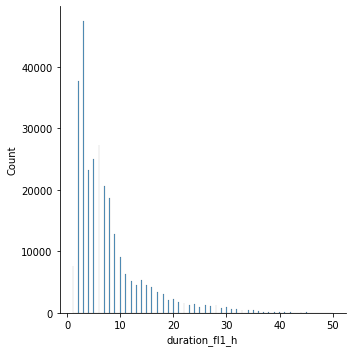

In [675]:
# segmenting the durations of flights

sns.displot(
    round(srch9[srch9["duration_fl1_h"] < 50]["duration_fl1_h"]), bins=300, kde=False
)

In [676]:
srch9["duration_fl1_h"]

0          5.100000
1          5.000000
2          7.250000
3          7.183333
4          6.683333
            ...    
998393    14.416667
998394     7.166667
998395     1.833333
998396    14.416667
998397     1.750000
Name: duration_fl1_h, Length: 287244, dtype: float64

In [677]:
srch9["duration_fl1_h_cat"] = srch9["duration_fl1_h"].apply(
    lambda x: np.where(np.isnan(x), -1, 40) if (x >= 40) else round(x)
)

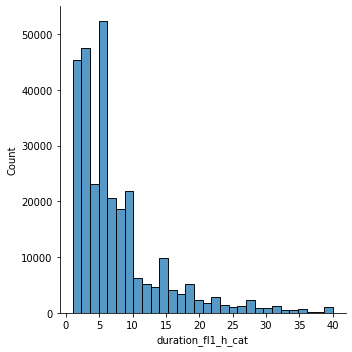

In [678]:
sns.displot(srch9["duration_fl1_h_cat"], bins=30, kde=False)

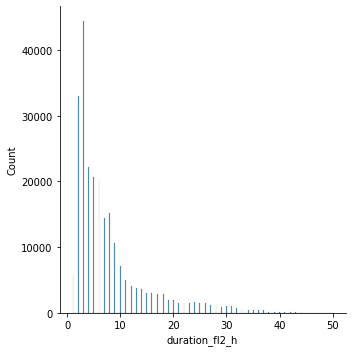

In [679]:
sns.displot(
    round(srch9[srch9["duration_fl2_h"] < 50]["duration_fl2_h"]), bins=300, kde=False
)

In [680]:
srch9["duration_fl2_h"] = srch9["duration_fl2_h"].fillna(-1).astype(int)
srch9["duration_fl2_h_cat"] = srch9["duration_fl2_h"].apply(
    lambda x: np.where(np.isnan(x), np.nan, 40) if (x >= 40) else round(x)
)

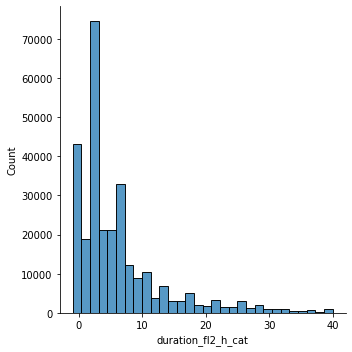

In [681]:
sns.displot(srch9["duration_fl2_h_cat"], bins=30, kde=False)

In [682]:
# splitting aggregated airlines data

srch9[["carrier_11", "carrier_12"]] = srch9["carrier_1"].str.split(";", 1, expand=True)

In [683]:
df10 = pd.DataFrame(
    srch9.groupby(["carrier_11", "carrier_12"])
    .agg({"itinerary_id": "count"})
    .to_records()
)
df10[df10["itinerary_id"] > 25]

,carrier_11,carrier_12,itinerary_id
30,9W,9W,31
31,9W,9W; 9W,30
48,AA,AA,1583
49,AA,AA; AA,113
85,AB,AB,99
...,...,...,...
1545,WW,LH,27
1558,WW,SK,36
1566,WW,U2,299
1570,WW,VY,36


In [684]:
srch9[["carrier_21", "carrier_22"]] = srch9["carrier_2"].str.split(";", 1, expand=True)

In [685]:
df11 = pd.DataFrame(
    srch7.groupby(["carrier_2"]).agg({"itinerary_id": "count"}).to_records()
)

In [686]:
df11[df11["itinerary_id"] > 25]

,carrier_2,itinerary_id
150,4O,37
163,4U,33
200,5J,60
348,9W,39
351,9W; 9W,88
...,...,...
9190,WW; WW,46
9217,WY; WY,31
9248,XK,37
9309,Y4,65


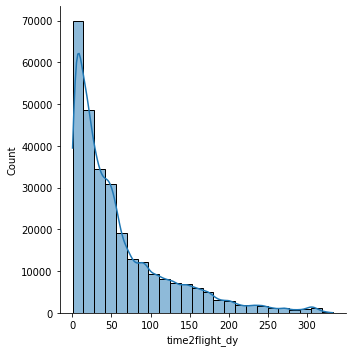

In [687]:
# binning the time2flight feature

sns.displot(srch9["time2flight_dy"], bins=24, kde=True)

In [688]:
srch9["time2flight_dy"] = srch9["time2flight_dy"].apply(
    lambda x: np.where(np.isnan(x), -1, 400) if (x >= 400) else round(x)
)

In [689]:
# Looking for extram periods o filights according to fare of ticket

df12 = pd.DataFrame(
    srch9.groupby(pd.to_datetime(
    srch9["departure_datetime_11"], format="%d/%m/%Y"
).dt.date).agg({"fare_usd": "mean"}).to_records()
)

Text(0, 0.5, 'Fare')

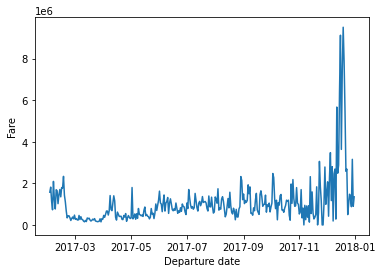

In [690]:
plt.plot(df12['departure_datetime_11'], df12['fare_usd'])
plt.xlabel("Departure date")
plt.ylabel("Fare")

Text(0, 0.5, 'Fare')

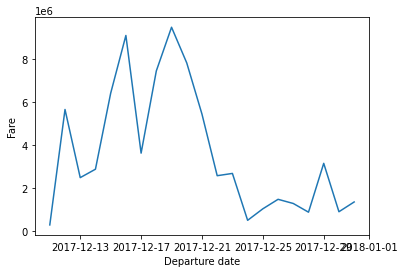

In [691]:
plt.plot(df12[(df12["departure_datetime_11"] > dt.date(2017, 12, 10))]['departure_datetime_11'], df12[(df12["departure_datetime_11"] > dt.date(2017, 12, 10))]['fare_usd'])
plt.xlabel("Departure date")
plt.ylabel("Fare")

In [693]:
# Not taking into account Christams Holidays period

srch9 = srch9[~((srch9["departure_datetime_11"] > '2017-12-10 00:00:00')
 & (srch9['departure_datetime_11']<'2017-12-24 00:00:00'))]

In [694]:
df13 = pd.DataFrame(
    srch9.groupby(pd.to_datetime(
    srch9["departure_datetime_11"], format="%d/%m/%Y"
).dt.date).agg({"fare_usd": "mean"}).to_records()
)

Text(0, 0.5, 'Fare')

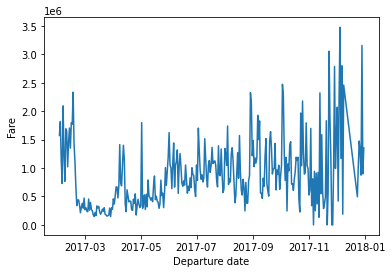

In [697]:
plt.plot(df13['departure_datetime_11'], df13['fare_usd'])
plt.xlabel("Departure date")
plt.ylabel("Fare")

In [696]:
df13[(df13["fare_usd"] >2500000 )]

,departure_datetime_11,fare_usd
295,2017-11-23,3.054219e+06
301,2017-11-29,2.784476e+06
307,2017-12-05,3.474933e+06
309,2017-12-07,2.797263e+06
317,2017-12-29,3.154168e+06


In [698]:
# Deleting additional too high fare value dates of flight

srch9 = srch9[~
    (
    (srch9["departure_datetime_11"].dt.date == dt.date(2017, 11, 23))
    | (srch9["departure_datetime_11"].dt.date == dt.date(2017, 11, 29))
    | (srch9["departure_datetime_11"].dt.date == dt.date(2017, 12, 5))
    | (srch9["departure_datetime_11"].dt.date == dt.date(2017, 12, 7))
    | (srch9["departure_datetime_11"].dt.date == dt.date(2017, 12, 29))
    )]

In [699]:
arp2_dst.rename(
    columns={
        "city": "city_dst",
        "iata_code": "iata_code_dst",
        "altitude": "altitude_dst",
        "aggregate_code": "aggregate_code_dst",
        "country": "country_dst",
    },
    inplace=True,
)
srch9 = pd.merge(
    srch9,
    arp2_dst[
        [
            "iata_code_dst",
            "city_dst",
            "altitude_dst",
            "aggregate_code_dst",
            "country_dst",
        ]
    ],
    left_on=["destination"],
    right_on=["iata_code_dst"],
    how="inner",
)

In [700]:
srch9.drop(
    [
        "iata_code_dst_x",
        "iata_code_dst"
    ],
    axis=1,
    inplace=True,
)

In [701]:
# droping unneeded data

srch9.drop(
    [
        "search_user_id",
        "session_id",
        "user_agent",
        "fare",
        "carrier_1",
        "carrier_2",
        "flight_num_1",
        "flight_num_2",
        "dst_org",
        "dst_dst",
        "departure_datetime_11",
        "departure_datetime_21",
        "departure_datetime_1",
        "arrival_datetime_1",
        "departure_datetime_2",
        "arrival_datetime_2",
        "iata_code_org",
        "city",
        "latitude",
        "longitude",
        "tz_o",
        "tz_d",
        "departure_datetime_11_tz",
        "departure_datetime_21_tz",
        "departure_datetime_11_utc",
        "departure_datetime_21_utc",
        "arrival_1_last_utc",
        "arrival_1_last_tz",
        "arrival_2_last_utc",
        "arrival_2_last_tz",
        "duration_fl1_h",
        "duration_fl2_h",
        "iata_code_dst_y",
        "latitude_dst",
        "longitude_dst",
        "distance_km",
        "departure_1_hour",
        "arrival_1_hour",
        "departure_2_hour",
        "arrival_2_hour",
        "search_time_hour",
        "agent_rest1",
        "agent_trash",
        "agent_rest2",
        "agent_rest3",
        "distance_cat",
        "curr2usd",
    ],
    axis=1,
    inplace=True,
)

In [702]:
# limitin data of search to not older then 90 days before departure

srch10 = srch9[srch9["time2flight_dy"] < 90].copy()

In [703]:
srch10.head(5).T

,0,1,2,3,4
search_id,02c6c2ad-325b-4155-bb03-89badc92ea84,930a8b7b-26fb-44cd-80b9-143230b00395,04e7effa-d99a-4192-9584-cd28e3e7bd99,01c6c47b-c66e-4afd-bb4c-df5f272f4710,0309368f-f91a-43d3-a0ec-656ded9ec837
search_time,2017-02-01 00:00:07,2017-02-01 02:46:35,2017-02-01 03:17:26,2017-02-01 05:20:04,2017-02-01 20:09:36
currency,USD,USD,USD,USD,USD
destination,MIA,MIA,MIA,MIA,MIA
language,en,en,en,en,en
origin,LAX,LAX,LAX,LAX,LAX
partner_id,294,91,91,91,91
passengers,1,1,1,2,1
pos,US,US,US,US,US
num_requests,1,1,1,1,1


In [704]:
master = srch10.copy()

In [705]:
master = pd.merge(
    srch10[["search_id", "fare_usd"]], srch10, on=["search_id"], how="inner"
).copy()

In [706]:
master.drop(["search_id", "fare_usd_y"], axis=1, inplace=True)

DEVELOPING MODEL FOR PRICE PREDICTION
1. In step of preprocessing categorical data were encoded to numerical ones
2. Based on correlation matrix - features strongly correlated to each over were droped
3. Data were rescaled
4. Three models were used for benchmark: Random Forest, XFBoost and NN MLP all with mae (mean ablsolute error) evaluation metrics function
5. Time2flight MAE distribution will be ploted after successful calculation of models as dashboard of model performance

In [707]:
import random
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler

In [708]:
from sklearn import preprocessing


def convert(data):
    number = preprocessing.LabelEncoder()
    data["currency"] = number.fit_transform(data["currency"])
    data["destination"] = number.fit_transform(data["destination"])
    data["language"] = number.fit_transform(data["language"])
    data["origin"] = number.fit_transform(data["origin"])
    data["pos"] = number.fit_transform(data["pos"])
    data["cabin_class"] = number.fit_transform(data["cabin_class"])
    data["country"] = number.fit_transform(data["country"])
    data["country_dst"] = number.fit_transform(data["country_dst"])
    data["os"] = number.fit_transform(data["os"])
    data["carrier_11"] = number.fit_transform(data["carrier_11"])
    data["carrier_12"] = number.fit_transform(data["carrier_12"])
    data["carrier_21"] = number.fit_transform(data["carrier_21"])
    data["carrier_22"] = number.fit_transform(data["carrier_22"])
    data["search_time_hour_cat"] = number.fit_transform(data["search_time_hour_cat"])
    data["departure_1_hour_cat"] = number.fit_transform(data["departure_1_hour_cat"])
    data["departure_2_hour_cat"] = number.fit_transform(data["departure_2_hour_cat"])
    data["arrival_1_hour_cat"] = number.fit_transform(data["arrival_1_hour_cat"])
    data["arrival_2_hour_cat"] = number.fit_transform(data["arrival_2_hour_cat"])
    data["agent"] = number.fit_transform(data["agent"])
    data = data.fillna(-9999)
    return data


master = convert(master)

<AxesSubplot:>

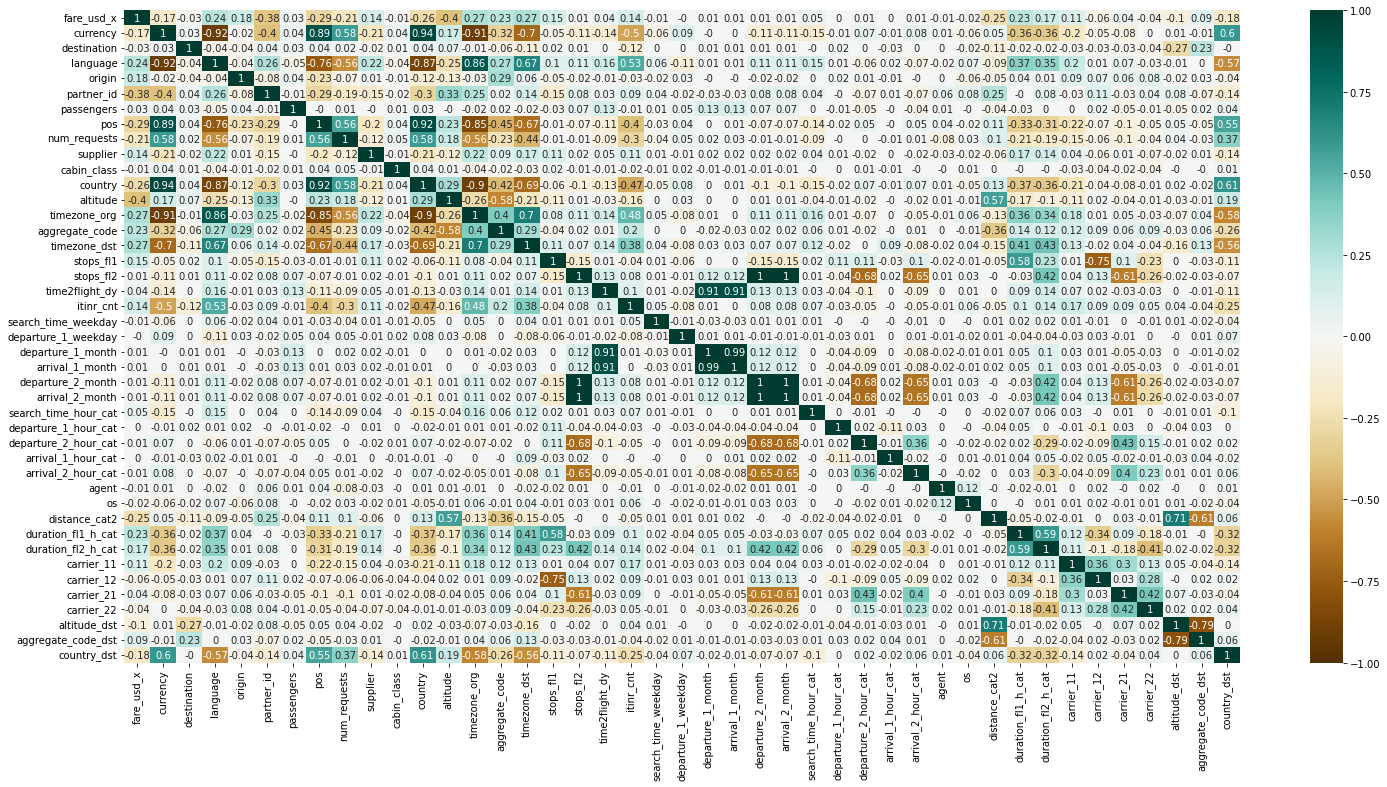

In [709]:
plt.figure(figsize=(25, 12))
sns.heatmap(master.corr().round(2), vmin=-1, vmax=1, annot=True, cmap="BrBG")

In [710]:
master.drop(['currency','language','pos','country','stops_fl2','departure_1_month','arrival_1_month','arrival_2_month','search_time','search_time','city_dst','itinerary_id'],axis=1,inplace=True)
#master.drop(["search_time"], axis=1, inplace=True)

In [711]:
master.isna().sum()

fare_usd_x              0
destination             0
origin                  0
partner_id              0
passengers              0
num_requests            0
supplier                0
cabin_class             0
altitude                0
timezone_org            0
aggregate_code          0
timezone_dst            0
stops_fl1               0
time2flight_dy          0
itinr_cnt               0
search_time_weekday     0
departure_1_weekday     0
departure_2_month       0
search_time_hour_cat    0
departure_1_hour_cat    0
departure_2_hour_cat    0
arrival_1_hour_cat      0
arrival_2_hour_cat      0
agent                   0
os                      0
distance_cat2           0
duration_fl1_h_cat      0
duration_fl2_h_cat      0
carrier_11              0
carrier_12              0
carrier_21              0
carrier_22              0
altitude_dst            0
aggregate_code_dst      0
country_dst             0
dtype: int64

In [712]:
master.nunique()

fare_usd_x              46551
destination               155
origin                     69
partner_id                  9
passengers                 13
num_requests              192
supplier                  112
cabin_class                 6
altitude                   53
timezone_org                9
aggregate_code              2
timezone_dst               18
stops_fl1                   4
time2flight_dy             90
itinr_cnt                 105
search_time_weekday         7
departure_1_weekday         7
departure_2_month          13
search_time_hour_cat        3
departure_1_hour_cat        4
departure_2_hour_cat        5
arrival_1_hour_cat          4
arrival_2_hour_cat          5
agent                       3
os                        204
distance_cat2              15
duration_fl1_h_cat         40
duration_fl2_h_cat         42
carrier_11                147
carrier_12                517
carrier_21                194
carrier_22                375
altitude_dst              107
aggregate_

In [713]:
master.head().T

,0,1,2,3,4
fare_usd_x,499.0,331.4,129.82,416.0,380.1
destination,83.0,83.0,83.00,83.0,83.0
origin,30.0,30.0,30.00,30.0,30.0
partner_id,294.0,91.0,91.00,91.0,91.0
passengers,1.0,1.0,1.00,2.0,1.0
num_requests,1.0,1.0,1.00,1.0,1.0
supplier,22.0,91.0,91.00,91.0,91.0
cabin_class,2.0,2.0,2.00,2.0,2.0
altitude,126.0,126.0,126.00,126.0,126.0
timezone_org,-8.0,-8.0,-8.00,-8.0,-8.0


master.drop(["itinerary_id"], axis=1, inplace=True)

In [714]:
random.seed(50)

X = master.iloc[:, 1:].values
y = master.iloc[:, 0].values
print(pd.Series(y).value_counts())

366.400     457
266.400     330
316.400     301
183.200     261
256.400     242
           ... 
168.970       1
1059.500      1
681.000       1
126.500       1
29.493        1
Length: 46551, dtype: int64


In [715]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=322
)

scaler = RobustScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
svr_rbf = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
svr_rbf.fit(X_train_sc, y_train)

In [716]:
scaler = RobustScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=2,
    bootstrap=True,
    max_features="auto",
)
rf.fit(X_train_sc, y_train)

In [ ]:
xgbr = xgb.XGBRegressor(base_score=0.5, booster='gblinear', eval_metric= 'mae',
                        #colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, 
                        #max_delta_step=0, max_depth=3, min_child_weight=1, 
                        missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, 
                        #subsample=1, 
                        verbosity=1) 

xgbr.fit(X_train_sc, y_train)

In [717]:
train = xgb.DMatrix(X_train_sc, label=y_train)
test = xgb.DMatrix(X_test_sc, label=y_test)
param = {
    "max_depth": 15,
    "eta": 1,
    "silent": 1,
#    "booster":"gblinear",
#    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "learning_rate": 0.1,
}
evallist = [(train, "train"), (test, "validation")]

In [718]:
# XGBRegressor
results = dict()

xgbm = xgb.train(
    param,  # słownik paramterów
    train,  # zbior treningowy
    100,  # ile drzew
    evallist,  # watchlista
    evals_result=results,
    early_stopping_rounds=10,  # stop jeśli nie ma poprawy
)

/home/dsl/.local/lib/python3.8/site-packages/xgboost/core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[16:29:12] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-mae:370828.73894	validation-mae:377552.85468
[1]	train-mae:337719.33100	validation-mae:346393.46820
[2]	train-mae:307848.01865	validation-mae:318758.75667
[3]	train-mae:280868.63388	validation-mae:294224.34411
[4]	train-mae:256490.21026	validation-mae:272547.00313
[5]	train-mae:234351.00125	validation-mae:252810.46873
[6]	train-mae:214491.16679	validation-mae:235245.39111
[7]	train-mae:196569.58332	validation-mae:220008.79726
[8]	train-mae:180391.67200	validation-mae:206427.47998
[9]	train-mae:165861.52579	validation-mae:194453.79274
[10]	train-mae:152785.70361	validation-mae:184202.23844
[11]	train-mae:141089.83372	validatio

In [719]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

from pylab import rcParams
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers

In [739]:
# Input
inputs = tf.keras.Input(shape=(X_train.shape[1],))  # Returns an input placeholder
# 1 HL
x = layers.Dense(16, activation='relu')(inputs)
#2 HL
x = layers.Dense(16, activation='relu')(x)
#3 HL
x = layers.Dense(16, activation='relu')(x)
#4 HL
x = layers.Dense(16, activation='relu')(x)
#5 HL
x = layers.Dense(16, activation='relu')(x)
# output
predictions = layers.Dense(1, activation='linear')(x)

# Define model
model = tf.keras.Model(inputs=inputs, outputs=predictions)

model.compile(optimizer="rmsprop",
              loss='mse',
              metrics=['mae'])

callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
#    ,
# tf.keras.callbacks.TensorBoard(log_dir='.\\logs',profile_batch=0)
  ]

#model.fit(X_train, y_train, batch_size=128, epochs=10)

model.fit(X_train_sc,y_train,epochs=100 , batch_size=32,
                    callbacks=callbacks, validation_split=.2)

Epoch 1/100
4430/4430 [==============================] - 7s 1ms/step - loss: 4137395945472.0000 - mae: 420536.1875 - val_loss: 2792366276608.0000 - val_mae: 292117.0000
Epoch 2/100
4430/4430 [==============================] - 6s 1ms/step - loss: 2908790456320.0000 - mae: 246168.2656 - val_loss: 2679720378368.0000 - val_mae: 232935.7969
Epoch 3/100
4430/4430 [==============================] - 6s 1ms/step - loss: 2838126919680.0000 - mae: 227954.8750 - val_loss: 2617573900288.0000 - val_mae: 244563.4688
Epoch 4/100
4430/4430 [==============================] - 7s 1ms/step - loss: 2788650909696.0000 - mae: 222517.1094 - val_loss: 2578558484480.0000 - val_mae: 223235.1562
Epoch 5/100
4430/4430 [==============================] - 7s 2ms/step - loss: 2745950011392.0000 - mae: 217983.2812 - val_loss: 2538171531264.0000 - val_mae: 217790.9531
Epoch 6/100
4430/4430 [==============================] - 6s 1ms/step - loss: 2704431906816.0000 - mae: 211366.9375 - val_loss: 2502763216896.0000 - val_mae

In [721]:
model.summary()

Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 34)]              0         
                                                                 
 dense_173 (Dense)           (None, 64)                2240      
                                                                 
 dense_174 (Dense)           (None, 64)                4160      
                                                                 
 dense_175 (Dense)           (None, 64)                4160      
                                                                 
 dense_176 (Dense)           (None, 1)                 65        
                                                                 
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
_________________________________________________________________


In [740]:
pred_rf = rf.predict(X_test_sc)
pred_xgbm = xgbm.predict(test)
pred_xgbr = xgbr.predict(X_test_sc)
pred_tf = model.predict(X_test_sc,batch_size=32)

print("MAE RF:", metrics.mean_absolute_error(y_test, pred_rf))
print("MAE XGBM:", metrics.mean_absolute_error(y_test, pred_xgbm))
print("MAE TF:", metrics.mean_absolute_error(y_test, pred_tf))

1385/1385 [==============================] - 1s 794us/step
MAE RF: 135476.47047028432
MAE XGBM: 129199.55610363996
MAE TF: 179148.1808009111


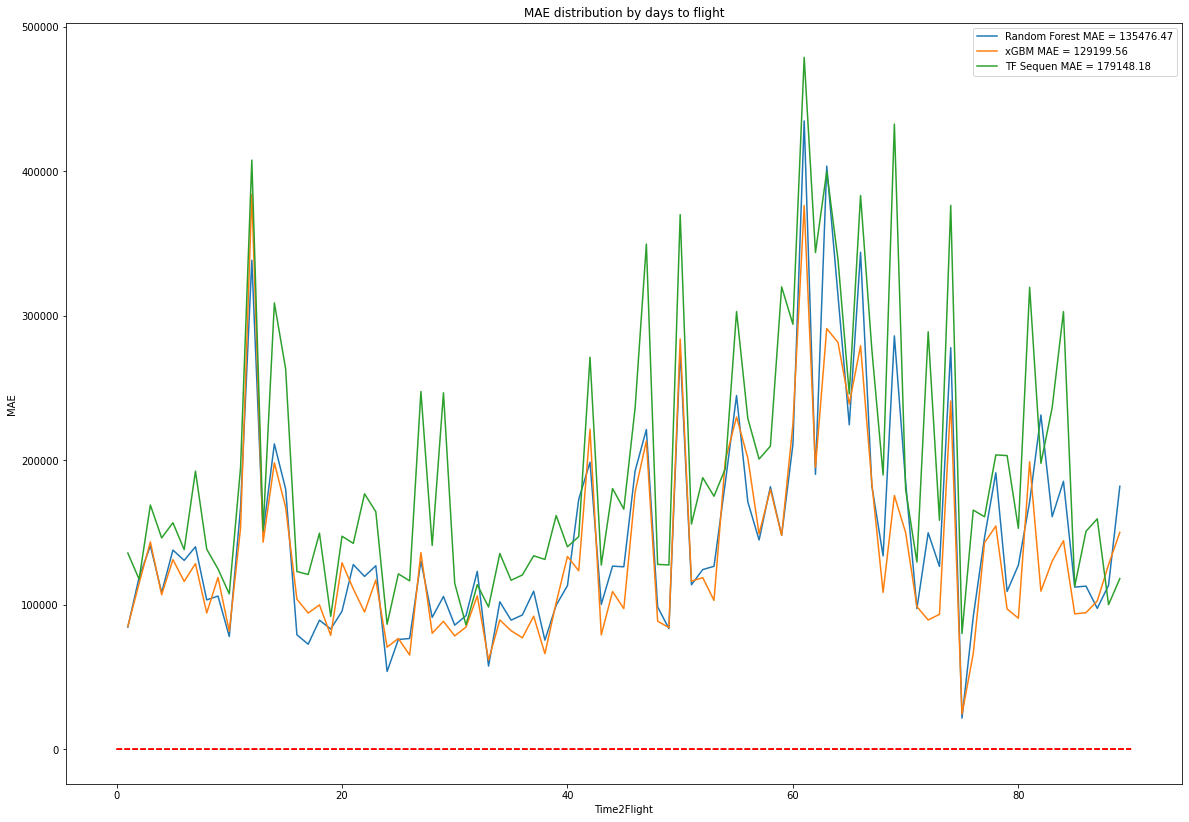

In [741]:
def plot_mae(X_test,y_test, prob, model_name = ""):
    
    X_test_unsc=scaler.inverse_transform(X_test)
    mae, time2flight=[], []

    for i in range(1,90):
        time2flight.append(i)
        at_index =np.where(X_test_unsc[:,12]==i)
        yi_test=(y_test.take(at_index))
        prob_i=(prob.take(at_index))
        mae.append(metrics.mean_absolute_error(yi_test,prob_i))
    
    plt.plot(time2flight, mae, label = "{} MAE = {}".format(model_name, metrics.mean_absolute_error(y_test, prob).round(2)))
    plt.plot([0,90], [0,90], 'r--')
    plt.xlabel("Time2Flight")
    plt.ylabel("MAE")
    plt.title("MAE distribution by days to flight")
    plt.legend()

plt.figure(figsize=[20,14])
    
plot_mae(X_test_sc,y_test, pred_rf, model_name = "Random Forest")
plot_mae(X_test_sc,y_test, pred_xgbm, model_name = "xGBM")
plot_mae(X_test_sc,y_test, pred_tf, model_name = "TF Sequen")